# HRD Differential Expression Runs for All Relevant Dendrogroup Comparisons

## 1 Data pre-processing

In [1]:
%load_ext autoreload
%autoreload 2
# Import libraries
import pandas as pd
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import spearmanr, ttest_ind
from statsmodels.stats.multitest import multipletests
import json
import os
import rpy2
import re
%load_ext rpy2.ipython

sys.path.append("../funcs/")
import utils
import proteomics as prot
import plotting as pl
import ms_utils

sys.path.append("../scripts/")
import diffexp_wrapper


In [2]:
KEGG_PATH = '../data/genesets/c2.cp.kegg.v7.4.symbols.gmt'
HALLMARK_PATH = '../data/genesets/h.all.v7.4.symbols.gmt'
REACTOME_PATH = '../data/genesets/ReactomePathways_ddr.gmt'
GENESET_PATH = "../data/genesets/full_geneset.json"
FEATURE_MAP = "../data/var_map_full_v4.tsv"

H_MUT_PATH = "results/Full_H_compressed_v2.tsv"
SAMPLE_MAP_PATH = "../data/ref/PanCan_Participant_freeze_mapping.tsv"
DENDRO_PATH = "../data/dendrogram_split_map.tsv"

# Data paths: These files must be downloaded, 
# and the paths must be changed to their corresponding path on the local machine
RNA_PATH = "../data/raw/tumor_rna_counts_pc_X.tsv"
PROTEOME_RAW_PATH = "../data/raw/proteome_gene_centric.tsv.gz"
PHOSPHO_CORRECTED_PATH = "../data/ptm_residuals/phosphoproteome_raw_res_X.tsv"
ACETYL_CORRECTED_PATH = "../data/ptm_residuals/acetylome_raw_res_X.tsv"
PHOSPHO_RAW_PATH = "../data/raw/phosphoproteome_X.tsv.gz"
ACETYL_RAW_PATH = "../data/raw/acetylome_X.tsv.gz"


In [3]:
# Load geneset
gs_d = {}
with open(GENESET_PATH, "r") as f:
    gs_d = json.load(f)


In [4]:
# Load important data
H_mut = pd.read_csv(H_MUT_PATH, sep='\t',index_col=0)
dendrogroup_map = pd.read_csv(DENDRO_PATH, sep='\t', index_col=0)
sample_map = pd.read_csv(SAMPLE_MAP_PATH, sep='\t')
dendrogroup_map.index = dendrogroup_map.index.astype(str)
sample_map.index = sample_map.index.astype(str)

# Annotate with cohort
dendrogroup_map['cohort'] = dendrogroup_map.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort'])

# Standardize sample naming schema
H_mut.index = H_mut.index.map(sample_map.set_index('WXS').to_dict()['Proteome_Sample_ID']).astype(str)

# Subset for patients with mutational data and dendro data
not_shared = [x for x in H_mut.index if x not in dendrogroup_map.index.to_list()]
print(f"Patients with mutation data but no dendro data: {not_shared}")
H_mut = H_mut.loc[np.intersect1d(H_mut.index, dendrogroup_map.index)]
sample_map = sample_map[sample_map['Proteome_Sample_ID'].isin(H_mut.index.to_list())]

# Define HRD patients
HRD_patients = H_mut[H_mut['HRD']>=45].index.to_list()


Patients with mutation data but no dendro data: ['X03BR011']


In [5]:
def run_HRD_DE(formats, outDir, pov_id, acetylome=False, subset=None):
    formats["out_limma"] = os.path.join(outDir, "analysis_files")
    diffexp_wrapper.run_differential_expression(formats=formats, scripts_dir=formats["scripts_dir"])
    
    protein_map = pd.read_csv(FEATURE_MAP,sep='\t',index_col='id')
    full_de_df = pd.read_csv(os.path.join(outDir, "analysis_files", "full_diffexp_results.tsv"),sep='\t',index_col=0)
    full_de_df['feature'] = full_de_df['feature'].map(lambda x: x if x==x  else 'proteome')
    full_de_df['gene_name'] = full_de_df.apply(lambda x: x['gene_name'] if x['feature'] in 
                                               ['transcriptome','phosphoproteome','acetylome','phosphoproteome_res',
                                               'acetylome_res'] else x.name, 1) 
    full_de_df.to_csv(os.path.join(outDir, "analysis_files", "full_diffexp_results.tsv"), sep='\t')
    full_de_df = full_de_df[full_de_df['id']==pov_id]
    
    # Subset for genes and recompute FDR
    subset_corrected_df = pd.DataFrame()
    if subset != None:
        subset_df = full_de_df[full_de_df['gene_name'].isin(subset)]
        for feat, feat_df in subset_df.groupby('feature'):
            feat_df['adj.P.Val'] = multipletests(feat_df['P.Value'], method="fdr_bh")[1]
            feat_df['qval'] = prot.qvalue(feat_df['P.Value'])[0]
            subset_corrected_df = pd.concat([subset_corrected_df, feat_df])
        subset_corrected_df.to_csv(os.path.join(outDir, "analysis_files", "DDR_diffexp_results.tsv"), sep='\t')
    
    # Prep GSEA
    rna_gsea_rank = utils.prepGSEA(full_de_df, feature='transcriptome', group=pov_id, rank_col='gsea_rank_p')
    prot_gsea_rank = utils.prepGSEA(full_de_df, feature='proteome', group=pov_id, rank_col='gsea_rank_p')
    phospho_gsea_rank = utils.prepGSEA(full_de_df, feature='phosphoproteome', group=pov_id, rank_col='gsea_rank_p')
    phospho_res_gsea_rank = utils.prepGSEA(full_de_df, feature='phosphoproteome_res', group=pov_id, rank_col='gsea_rank_p')
    if acetylome:
        acetyl_gsea_rank = utils.prepGSEA(full_de_df, feature='acetylome', group=pov_id, rank_col='gsea_rank_p')
        acetyl_res_gsea_rank = utils.prepGSEA(full_de_df, feature='acetylome_res', group=pov_id, rank_col='gsea_rank_p')
    phospho_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='phosphoproteome') & 
                                                     ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                          method='fdr_bh')
    phospho_maxsig_gsea_rank = utils.prepGSEA(phospho_collapsed, feature='phosphoproteome', group=pov_id, rank_col='gsea_rank_p')
    if acetylome:
        acetyl_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='acetylome') & 
                                                        ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                              method='fdr_bh')
        acetyl_maxsig_gsea_rank = utils.prepGSEA(acetyl_collapsed, feature='acetylome', group=pov_id, rank_col='gsea_rank_p')
    phospho_res_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='phosphoproteome_res') & 
                                                     ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                          method='fdr_bh')
    phospho_res_maxsig_gsea_rank = utils.prepGSEA(phospho_res_collapsed, feature='phosphoproteome_res', group=pov_id, rank_col='gsea_rank_p')
    if acetylome:
        acetyl_res_collapsed = prot.ptm_pval_fdr(full_de_df[(full_de_df['feature']=='acetylome_res') & 
                                                         ~full_de_df['P.Value'].isna()], protein_map=protein_map,
                                              method='fdr_bh')
        acetyl_res_maxsig_gsea_rank = utils.prepGSEA(acetyl_res_collapsed, feature='acetylome_res', group=pov_id, rank_col='gsea_rank_p')

    pathway_list = ['KEGG','HALLMARK','REACTOME_DDR']
    pathway_dict = {'KEGG':KEGG_PATH, 'HALLMARK':HALLMARK_PATH, 'REACTOME_DDR':REACTOME_PATH}
    feature_list = ['Transcriptome','Proteome','Phosphoproteome','Phosphoproteome Max Sig',
                   'Phosphoproteome Res.', 'Phosphoproteome Res. Max Sig']
    feature_dict = {'Transcriptome':rna_gsea_rank, 'Proteome':prot_gsea_rank, 'Phosphoproteome':phospho_gsea_rank,
                    'Phosphoproteome Max Sig':phospho_maxsig_gsea_rank, 
                    'Phosphoproteome Res.':phospho_res_gsea_rank,
                    'Phosphoproteome Res. Max Sig':phospho_res_maxsig_gsea_rank,}
    if acetylome:
        feature_list += ['Acetylome', 'Acetylome Max Sig', 'Acetylome Res.', 'Acetylome Res. Max Sig']
        feature_dict['Acetylome'] = acetyl_gsea_rank
        feature_dict['Acetylome Max Sig'] = acetyl_maxsig_gsea_rank
        feature_dict['Acetylome Res.'] = acetyl_res_gsea_rank
        feature_dict['Acetylome Res. Max Sig'] = acetyl_res_maxsig_gsea_rank
    gsea_res = pd.DataFrame(columns=['pathway','pval','padj','ES','NES','nMoreExtreme','size','leadingEdge','qval',
                                    'feature','id','geneset'])
    for pathway in pathway_list:
        for feature in feature_list:
            print(f"Running {feature} on {pathway}")
            temp_df = prot.rfgsea(feature_dict[feature],pathway_dict[pathway]).sort_values(by='qval')
            temp_df['feature'] = feature
            temp_df['geneset'] = pathway
            gsea_res = pd.concat([gsea_res,temp_df])
    gsea_res['id'] = pov_id # For HRD vs HRP
    gsea_res.to_csv(os.path.join(outDir, "analysis_files", "full_gsea.tsv"), sep='\t',index=False)


## 2 Global analysis HRD vs HRP
Differential expression between BRCA and HGSC HRD tumors and the bottom 20% of BRCA and HGSC HRP samples with the lowest SBS3 signature weight. Exclude any MMRD and POLE-exo*/POLD1-exo* samples in the HRP group in order to control for a single repair deficiency in the differential expression analysis.

In [ ]:
# Identify HRP tumors by taking the bottom 20% of samples from HGSC and BRCA
hgsc_subset_H = H_mut[(H_mut.index.map(sample_map.set_index('Proteome_Sample_ID'
                                                         ).to_dict()['cohort']).isin(['HGSC'])) 
                    & (H_mut['MMRD']==0) & (H_mut['POLE']==0)
                   ].sort_values('HRD')
brca_subset_H = H_mut[(H_mut.index.map(sample_map.set_index('Proteome_Sample_ID'
                                                         ).to_dict()['cohort']).isin(['BRCA'])) 
                    & (H_mut['MMRD']==0) & (H_mut['POLE']==0)
                   ].sort_values('HRD')
hgsc_hrp_samples = hgsc_subset_H.iloc[:round(hgsc_subset_H.shape[0]*0.2)].index
brca_hrp_samples = brca_subset_H.iloc[:round(brca_subset_H.shape[0]*0.2)].index
hrp_samples = hgsc_hrp_samples.append(brca_hrp_samples)

# Identify HRD tumors. Exclude PDAC
hgsc_hrd_samples = H_mut[(H_mut.index.map(sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort'])=='HGSC') 
                    & (H_mut['HRD']>=45)].index
brca_hrd_samples = H_mut[(H_mut.index.map(sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort'])=='BRCA') 
                         & (H_mut['HRD']>=45)].index
hrd_samples = hgsc_hrd_samples.append(brca_hrd_samples)

print("Number of HRP tumors:")
print(f"\tBRCA: {len(brca_hrp_samples)}")
print(f"\tHGSC: {len(hgsc_hrp_samples)}")
print("Number of HRD tumors:")
print(f"\tBRCA: {len(hrd_samples)}")
print(f"\tHGSC: {len(hgsc_hrd_samples)}")

# Define file paths
HRD_GLOBAL_OUT = "DE_data/HRD_global/"
HRD_GLOBAL_INPUT = "DE_data/HRD_global/membership.tsv"
HRD_GLOBAL_COVAR = "DE_data/HRD_global/covar.tsv"

# Setup DE formats
formats = {}
formats["scripts_dir"] = "/home/yakiyama/CPTAC_PanCan_PTM_2023/scripts" # Change to appropriate full path
formats["transcriptome"] = RNA_PATH
formats["proteome"] = PROTEOME_RAW_PATH
formats["phosphoproteome"] = PHOSPHO_RAW_PATH
formats["phosphoproteome_res"] = PHOSPHO_CORRECTED_PATH
formats["acetylome"] = ACETYL_RAW_PATH
formats["acetylome_res"] = PHOSPHO_CORRECTED_PATH
formats["prot_maps"] = FEATURE_MAP
formats["minObs"] = "5"
formats["clust"] = "HR_Status"
formats["input"] = HRD_GLOBAL_INPUT
formats["covar"] = HRD_GLOBAL_COVAR
formats["out_limma"] = HRD_GLOBAL_OUT

# List all samples in HRD Global analysis
hrd_global_samples_s = hrd_samples.append(hrp_samples)

# Define membership dataframe
hrd_global_membership_df = pd.DataFrame(index=hrd_global_samples_s, columns=["HR_Status", "extra"])
hrd_global_membership_df["HR_Status"] = hrd_global_membership_df.index.map(lambda x: "HRD" if x in hrd_samples 
                                                                             else "HRP")
hrd_global_membership_df.to_csv(HRD_GLOBAL_INPUT, sep='\t')

# Define covariate dataframe
hrd_global_covar_df = pd.DataFrame(index=hrd_global_samples_s, columns=["cohort", "extra"])
hrd_global_covar_df["cohort"] = hrd_global_covar_df.index.map(
    sample_map.set_index("Proteome_Sample_ID").to_dict()['cohort'])
hrd_global_covar_df.to_csv(HRD_GLOBAL_COVAR, sep='\t')

# Run Differential Expression
run_HRD_DE(formats=formats, outDir=formats["out_limma"], pov_id="HRD", acetylome=True,
           subset=gs_d['DDR'])

## 2.2 Figures (Figure 3B)

In [3]:
de_df = pd.read_csv("DE_data/HRD_global/analysis_files/DDR_diffexp_results.tsv", 
                    sep='\t', index_col=0)

de_df['prot_residue'] = de_df.apply(
    lambda x: f"{x['gene_name']}-{re.sub('[a-z]', ', ', x.name.split('_')[2]).strip(', ')}" if 
    x['feature'] in ['acetylome', 'acetylome_res', 'phosphoproteome', 'phosphoproteome_res'] else 
    x['gene_name'], 1
)


In [4]:
%%R
library(ggplot2)
library(gridExtra)
library(grid)
library(dplyr)
source("../funcs/funcsR.R")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:gridExtra’:

    combine


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
%R -i de_df

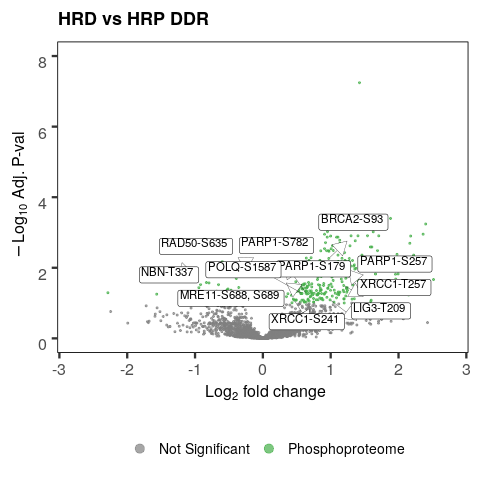

In [6]:
%%R
## Figure 3B: Bubble map for mutational signatures distribution
### Size of bubble: Proportion of patients in cohort that pass threshold
### Color of bubble: Median contribution of signature for patients in the
### cohort with the signature

plotVolcanoMultiOme <- function(de.df, w=10, h=16, xlim=NA, ylim=NA, 
                                gene.id='gene_name', genePTM=NULL, 
                                geneSelect=NULL, fcCut=0.05, pCut=0.1, 
                                lab.pval.thresh=NULL, ...){
    options(repr.plot.width=w, repr.plot.height=h)

    de.df[,gene.id] <- as.character(de.df[,gene.id])

    keyvals <- ifelse(
    de.df$adj.P.Val > pCut, '#808080',
      ifelse(abs(de.df$logFC) < fcCut, '#808080',
          ifelse(de.df$feature == 'transcriptome', '#FBB87C',
                 ifelse(de.df$feature == 'proteome', '#F16A84', '#45AF49')
          )
        )

    )

    names(keyvals)[keyvals == '#808080'] <- 'Not Significant'
    names(keyvals)[keyvals == '#FBB87C'] <- 'Transcriptome'
    names(keyvals)[keyvals == '#F16A84'] <- 'Proteome'
    names(keyvals)[keyvals == '#45AF49'] <- 'Phosphoproteome'
    # keyvals <- factor(keyvals, levels=c("#808080", "#FBB87C", "#F16A84", "#45AF49"))

    xmin <- NA
    xmax <- NA
    if (!is.na(xlim)) {
        xmin <- xlim[1]
        xmax <- xlim[2]
    }

    if(!is.null(genePTM)){
        selectLab <- unique(de.df[de.df$geneSymbol %in% intersect(genePTM,de.df$geneSymbol),]$geneSite)
        if(!is.null(lab.pval.thresh)){
            selectLab <- de.df[de.df$geneSite %in% selectLab & de.df$adj.P.Val<lab.pval.thresh,]$geneSite
        }
        EnhancedVolcano(de.df,
                        lab = de.df$geneSite,
                        x = 'logFC',
                        y = 'adj.P.Val',
                        pCutoff=pCut,
                        FCcutoff=fcCut,
                        xlim=c(xmin,xmax),
                        ylim=c(0,ylim),
                        col=c('#808080', '#FBB87C', '#F16A84', '45AF49'),
                        ylab = bquote(~-Log[10]~ 'Adj. P-val'),
                        colCustom = keyvals,
                        selectLab=selectLab,
                        ...
        )
    } else{
        EnhancedVolcano(de.df,
                        lab = de.df[,gene.id],
                        x = 'logFC',
                        y = 'adj.P.Val',
                        pCutoff=pCut,
                        FCcutoff=fcCut,
                        xlim=c(xmin,xmax),
                        ylim=c(0,ylim),
                        col=c('#808080', '#FBB87C', '#F16A84', '45AF49'),
                        ylab = bquote(~-Log[10]~ 'Adj. P-val'),
                        colCustom = keyvals,
                        ...
        )
    }
}

# de_df <- de_df[-which(de_df$feature %in% 
#                       c("phosphoproteome_res", "acetlyome", "acetylome_res")),]
de_df <- de_df[-which(de_df$feature %in% 
                      c("phosphoproteome_res", "acetlyome", "acetylome_res", 
                        'proteome', 'transcriptome')),]
options(ggrepel.max.overlaps=Inf)
hrd_hrp_plot <- plotVolcanoMultiOme(
    de_df, drawConnectors=T, widthConnectors=0.15, pointSize=0.75, labSize=4, 
    xlim=c(-2.75, 2.75), ylim=c(8, 0), title='HRD vs HRP DDR',
    subtitle=NULL, legendPosition='bottom', titleLabSize=18, axisLabSize=16, 
    cutoffLineWidth=0, caption=NULL, border='full', borderWidth=0.4, w=12, h=12,
    pCut=0.1, fcCut=0,
    gene.id='prot_residue',
    selectLab=c("BRCA2-S93","NBN-T337", "PARP1-S257", "XRCC1-T257", 
                "XRCC1-T257, S266s", "PARP1-S782", "PARP1-S179", "MRE11-S688, S689",
                'POLQ-S1587', 'RAD50-S635', 'XRCC1-S446, S447s',
                'LIG3-T209', 'XRCC1-S241'), 
    gridlines.major=FALSE, gridlines.minor=FALSE, boxedLabels=TRUE, 
    lengthConnectors=unit(0.05, "npc"), colAlpha=0.7)
pdf("figures/Figure_3B_hrd_hrp_volcano_test.pdf", width=8, height=10)
print(hrd_hrp_plot)
dev.off()
hrd_hrp_plot

## 3. Pairwise cluster differential expression analysis 

### 3.1 B vs C (acute vs chronic hypoxia HRD)

In [14]:
# Setup DE formats
formats = {}
formats["scripts_dir"] = "/home/yakiyama/CPTAC_PanCan_PTM_2023/scripts" 
formats["transcriptome"] = RNA_PATH
formats["proteome"] = PROTEOME_RAW_PATH
formats["phosphoproteome"] = PHOSPHO_RAW_PATH
formats["phosphoproteome_res"] = PHOSPHO_CORRECTED_PATH
formats["acetylome"] = ACETYL_RAW_PATH
formats["acetylome_res"] = PHOSPHO_CORRECTED_PATH
formats["prot_maps"] = FEATURE_MAP
formats["minObs"] = "5"

# Define cohort covariate dataframe
cohort_df = sample_map.set_index('Proteome_Sample_ID').loc[HRD_patients][['cohort']].copy()
cohort_df = cohort_df[cohort_df['cohort'].isin(['HGSC', 'BRCA'])]

# Set up dendrosplit mappings
hrd_dendro_df = dendrogroup_map.loc[HRD_patients]
hrd_dendro_df = hrd_dendro_df[hrd_dendro_df.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort']).isin(['HGSC','BRCA'])]


In [ ]:
# Define file paths
ACUTE_CHRONIC_INPUT = "DE_data/HRD_acute_chronic_hypoxia/dendro_membership.tsv"
COVAR_ACUTE_CHRONIC_INPUT = "DE_data/HRD_acute_chronic_hypoxia/covar.tsv"

# Set up inputs
# HRD3B vs HRD2A
formats["out_limma"] = "DE_data/HRD_acute_chronic_hypoxia/"
formats["clust"] = 'Acute_vs_Chronic_hypoxia'
includePatients_l = hrd_dendro_df[(hrd_dendro_df['X3']==False) | (hrd_dendro_df['X2']==True)].index
subset_hrd_dendro_df = hrd_dendro_df.loc[includePatients_l]
subset_hrd_dendro_df['Acute_vs_Chronic_hypoxia'] = subset_hrd_dendro_df.apply(
    lambda x: 'Acute Hypoxia' if x['X3']==False else 'Chronic Hypoxia', 1)
subset_hrd_dendro_df.to_csv(ACUTE_CHRONIC_INPUT, sep='\t')
subset_cohort_df = cohort_df.loc[includePatients_l]
subset_cohort_df['extra'] = np.nan
subset_cohort_df.to_csv(COVAR_ACUTE_CHRONIC_INPUT, sep='\t')

# Inputs
formats["input"] = ACUTE_CHRONIC_INPUT
formats["covar"] = COVAR_ACUTE_CHRONIC_INPUT

if 'acetylome_res' in formats:
    formats.pop('acetylome_res')
if 'acetylome' in formats:
    formats.pop('acetylome')

# Run DE
run_HRD_DE(formats=formats, outDir=formats["out_limma"], pov_id="Acute Hypoxia", acetylome=False,
          subset=gs_d['DDR'])

### 3.2 A vs B (lowest hypoxia vs intermediate hypoxia)

In [15]:
# Setup DE formats
formats = {}
formats["scripts_dir"] = "/home/yakiyama/CPTAC_PanCan_PTM_2023/scripts" 
formats["transcriptome"] = RNA_PATH
formats["proteome"] = PROTEOME_RAW_PATH
formats["phosphoproteome"] = PHOSPHO_RAW_PATH
formats["phosphoproteome_res"] = PHOSPHO_CORRECTED_PATH
formats["acetylome"] = ACETYL_RAW_PATH
formats["acetylome_res"] = PHOSPHO_CORRECTED_PATH
formats["prot_maps"] = FEATURE_MAP
formats["minObs"] = "5"

# Define cohort covariate dataframe
cohort_df = sample_map.set_index('Proteome_Sample_ID').loc[HRD_patients][['cohort']].copy()
cohort_df = cohort_df[cohort_df['cohort'].isin(['HGSC', 'BRCA'])]

# Set up dendrosplit mappings
hrd_dendro_df = dendrogroup_map.loc[HRD_patients]
hrd_dendro_df = hrd_dendro_df[hrd_dendro_df.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort']).isin(['HGSC','BRCA'])]

In [ ]:
# Define file paths
LOW_ACUTE_INPUT = "DE_data/HRD_low_acute_hypoxia/dendro_membership.tsv"
COVAR_LOW_ACUTE_INPUT = "DE_data/HRD_low_acute_hypoxia/covar.tsv"

# Set up inputs
# HRD3B vs HRD2A
formats["out_limma"] = "DE_data/HRD_low_acute_hypoxia/"
formats["clust"] = 'low_vs_acute_hypoxia'
includePatients_l = hrd_dendro_df[(hrd_dendro_df['X3']==False) | (hrd_dendro_df['X3']==True)].index
subset_hrd_dendro_df = hrd_dendro_df.loc[includePatients_l]
subset_hrd_dendro_df['low_vs_acute_hypoxia'] = subset_hrd_dendro_df.apply(
    lambda x: 'Acute Hypoxia' if x['X3']==False else 'Low Hypoxia', 1)
subset_hrd_dendro_df.to_csv(LOW_ACUTE_INPUT, sep='\t')
subset_cohort_df = cohort_df.loc[includePatients_l]
subset_cohort_df['extra'] = np.nan
subset_cohort_df.to_csv(COVAR_LOW_ACUTE_INPUT, sep='\t')

# Inputs
formats["input"] = LOW_ACUTE_INPUT
formats["covar"] = COVAR_LOW_ACUTE_INPUT

if 'acetylome_res' in formats:
    formats.pop('acetylome_res')
if 'acetylome' in formats:
    formats.pop('acetylome')

# Run DE
run_HRD_DE(formats=formats, outDir=formats["out_limma"], pov_id="Acute Hypoxia", acetylome=False,
          subset=gs_d['DDR'])

### 3.3 A vs C (lowest hypoxia vs highest hypoxia)

In [6]:
# Setup DE formats
formats = {}
formats["scripts_dir"] = "/home/yakiyama/CPTAC_PanCan_PTM_2023/scripts" 
formats["transcriptome"] = RNA_PATH
formats["proteome"] = PROTEOME_RAW_PATH
formats["phosphoproteome"] = PHOSPHO_RAW_PATH
formats["phosphoproteome_res"] = PHOSPHO_CORRECTED_PATH
formats["acetylome"] = ACETYL_RAW_PATH
formats["acetylome_res"] = PHOSPHO_CORRECTED_PATH
formats["prot_maps"] = FEATURE_MAP
formats["minObs"] = "5"

# Define cohort covariate dataframe
cohort_df = sample_map.set_index('Proteome_Sample_ID').loc[HRD_patients][['cohort']].copy()
cohort_df = cohort_df[cohort_df['cohort'].isin(['HGSC', 'BRCA'])]

# Set up dendrosplit mappings
hrd_dendro_df = dendrogroup_map.loc[HRD_patients]
hrd_dendro_df = hrd_dendro_df[hrd_dendro_df.index.map(
    sample_map.set_index('Proteome_Sample_ID').to_dict()['cohort']).isin(['HGSC','BRCA'])]

In [7]:
# Define file paths
LOW_CHRONIC_INPUT = "DE_data/HRD_low_chronic_hypoxia/dendro_membership.tsv"
COVAR_LOW_CHRONIC_INPUT = "DE_data/HRD_low_chronic_hypoxia/covar.tsv"

# Set up inputs
# HRD3B vs HRD2A
formats["out_limma"] = "DE_data/HRD_low_chronic_hypoxia/"
formats["clust"] = 'low_vs_chronic_hypoxia'
includePatients_l = hrd_dendro_df[(hrd_dendro_df['X2']==True) | (hrd_dendro_df['X3']==True)].index
subset_hrd_dendro_df = hrd_dendro_df.loc[includePatients_l]
subset_hrd_dendro_df['low_vs_chronic_hypoxia'] = subset_hrd_dendro_df.apply(
    lambda x: 'Chronic Hypoxia' if x['X2']==True else 'Low Hypoxia', 1)
subset_hrd_dendro_df.to_csv(LOW_CHRONIC_INPUT, sep='\t')
subset_cohort_df = cohort_df.loc[includePatients_l]
subset_cohort_df['extra'] = np.nan
subset_cohort_df.to_csv(COVAR_LOW_CHRONIC_INPUT, sep='\t')

# Inputs
formats["input"] = LOW_CHRONIC_INPUT
formats["covar"] = COVAR_LOW_CHRONIC_INPUT

if 'acetylome_res' in formats:
    formats.pop('acetylome_res')
if 'acetylome' in formats:
    formats.pop('acetylome')

# Run DE
run_HRD_DE(formats=formats, outDir=formats["out_limma"], pov_id="Chronic Hypoxia", acetylome=False,
          subset=gs_d['DDR'])

/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yakiyama/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
../scripts/diffexp_wrapper.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phosph_var['VMsiteFlanks_l'] = phosph_var['VMsiteFlanks'].apply(lambda x: x.replace('|', "', '")).apply(literal_eval)
../scripts/diffexp_wrapper.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Running Transcriptome on KEGG


/home/yakiyama/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Running Proteome on KEGG
Running Phosphoproteome on KEGG
Running Phosphoproteome Max Sig on KEGG
Running Phosphoproteome Res. on KEGG
Running Phosphoproteome Res. Max Sig on KEGG
Running Transcriptome on HALLMARK
Running Proteome on HALLMARK
Running Phosphoproteome on HALLMARK
Running Phosphoproteome Max Sig on HALLMARK
Running Phosphoproteome Res. on HALLMARK
Running Phosphoproteome Res. Max Sig on HALLMARK
Running Transcriptome on REACTOME_DDR


R[write to console]: Error in smooth.spline(lambda, pi0, df = smooth.df) : 
  missing or infinite values in inputs are not allowed

R[write to console]: In addition: 
R[write to console]: There were 39 warnings (use warnings() to see them)
R[write to console]: 



Running Proteome on REACTOME_DDR


R[write to console]: Error in smooth.spline(lambda, pi0, df = smooth.df) : 
  missing or infinite values in inputs are not allowed

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Running Phosphoproteome on REACTOME_DDR


R[write to console]: Error in smooth.spline(lambda, pi0, df = smooth.df) : 
  missing or infinite values in inputs are not allowed

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Running Phosphoproteome Max Sig on REACTOME_DDR


R[write to console]: Error in smooth.spline(lambda, pi0, df = smooth.df) : 
  missing or infinite values in inputs are not allowed

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Running Phosphoproteome Res. on REACTOME_DDR
Running Phosphoproteome Res. Max Sig on REACTOME_DDR


## 3.2 Figures (Figure 3D)

In [103]:
full_gsea_df = pd.read_csv(
    "DE_data/HRD_acute_chronic_hypoxia/analysis_files/full_gsea.tsv", 
    sep='\t')

In [113]:
%%R
library(ggplot2)
library(gridExtra)
library(grid)
library(dplyr)
source("../funcs/funcsR.R")

In [111]:
%R -i full_gsea_df

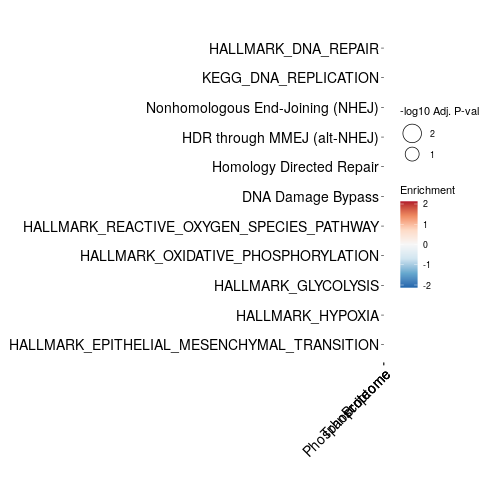

In [112]:
%%R
# GSEA Group3B vs Group2A
plotGSEA <- function(e_df, pval.thresh=0.1, filter=NULL, palette='RdBu', 
                     h=13, w=15, s_color='black', remove.not.sig=TRUE, order=NA){
    if(!is.null(filter)){
        e_df <- dplyr::filter(e_df, grepl(filter, pathway))
    }

    e_df$sig <- e_df$padj<pval.thresh
    e_df$logpval <- -log10(e_df$padj)

    if(remove.not.sig){
        e_df <- e_df[e_df$pathway %in% e_df[e_df$sig,]$pathway,]
    }

    ### Order axis by dendrogram
    # Load data
    X <- e_df[,c('pathway','feature','id','NES')]
    X$comb <- paste(X$feature,X$id)
    X <- reshape(X[,c('pathway','comb','NES')], timevar='comb', idvar='pathway',
                 direction='wide',)
    rownames(X) <- X$pathway
    X$pathway <- NULL

    X[is.na(X)] <- 0

    # Build the dendrogram
    dend <- as.dendrogram(hclust(d = dist(x = X)))
    dendro.plot <- ggdendrogram(dend,rotate = TRUE)

    # Use dendrogram order to order column
    if (is.na(order)){
        order <- order.dendrogram(dend) # dendrogram order
        e_df$pathway <- factor(x = e_df$pathway, levels = unique(e_df$pathway)[order], 
                               ordered = TRUE)
    } else {
        e_df$pathway <- factor(x = e_df$pathway, levels = order, ordered=TRUE)
    }

    ### Balloonplot
    options(repr.plot.width=w, repr.plot.height=h)

    p <- ggballoonplot(
        e_df,
        x="feature",
        y="pathway",
        fill = "NES",
        size="logpval",
        color=ifelse(e_df$sig==T, s_color, "lightgrey")
        ) +
        scale_fill_distiller(palette=palette, limit = max(abs(e_df$NES)) * c(-1, 1))+
        labs(x="", y="", fill="Enrichment", size="-log10 Adj. P-val") + theme_linedraw() +
        theme(axis.text.x=element_text(angle=45, hjust=1, size=14),
              axis.text.y=element_text(size=14)) +
        facet_grid(. ~ id, scales = "free", space = "free") +
        theme(strip.text.x = element_text(size=16))

    return(p)
}
full_gsea_df <- full_gsea_df[-which(full_gsea_df$feature %in% 
                                    c("Phosphoproteome Max Sig","Phosphoproteome Res. Max Sig",
                                      "Acetylome Max Sig", "Acetylome Res. Max Sig", 
                                      "Phosphoproteome Res.")), ]
includePath <- c("HALLMARK_DNA_REPAIR", "KEGG_DNA_REPLICATION", 
                 "KEGG_CITRATE_CYCLE_TAC_CYCLE", "Nonhomologous End-Joining (NHEJ)",
                 "HDR through MMEJ (alt-NHEJ)", "Homology Directed Repair",
                 "DNA Damage Bypass", "HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY",
                 "HALLMARK_OXIDATIVE_PHOSPHORYLATION", "HALLMARK_GLYCOLYSIS",
                 "HALLMARK_HYPOXIA", "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION")

group3b2a_gsea_df <- full_gsea_df[which(full_gsea_df$id == "HRD3Bvs2A_3B"),]
group3b2a_gsea_df$id <- replace(group3b2a_gsea_df$id, group3b2a_gsea_df$id=='HRD3Bvs2A_3B', 
                                'HRD Acute Hypoxia vs HRD Chronic Hypoxia')
group3b2a_gsea_df <- group3b2a_gsea_df[which(group3b2a_gsea_df$pathway %in% includePath),]

pdf("figures/Figure_3D_acute_chronic_gsea.pdf", height=5,width=12)
group3b2a_gsea_plot <- plotGSEA(group3b2a_gsea_df, order=rev(includePath))
print(group3b2a_gsea_plot)
dev.off()
group3b2a_gsea_plot